In [1]:
!pip install torchinfo
from torchinfo import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms.functional import rotate
from joblib import Parallel, delayed
import multiprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# avoiding the google colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

## Creating Regional Rotation Layer

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def rotate_mx(mx, degree):
	return rotate(mx.unsqueeze(0), degree).squeeze(0)

In [5]:
# calculating local binary pattern value
def LPB(mx):
  mid = mx.shape[0] // 2
  threshold = mx[mid, mid]

  bin_mx = (mx >= threshold)
  power_mx = torch.Tensor([
                       [1, 2, 4],
                       [8, 0, 16],
                       [32, 64, 128]
  ]).to(device)

  return (bin_mx * power_mx).sum()

In [6]:
# finding rotation matrix leading to minimum LPB value
def min_lpb(mx):
  num_of_surr_elements = mx.shape[0] ** 2 - 1
  rot_deg = 360 // num_of_surr_elements

  min_mx = mx.clone()
  lpb = LPB(mx)
  for degree in range(rot_deg, 360, rot_deg):
    mx = rotate_mx(mx, degree)
    cur_lpb = LPB(mx)

    if cur_lpb < lpb:
      lpb = cur_lpb
      min_mx = mx.clone()
     
  return min_mx

In [7]:
class RRL(nn.Module):
  def __init__(self, kernel_size=3, padding=(0, 0)):
    super(RRL, self).__init__()
    self.FH = self.FW = self.stride = kernel_size
    self.padding = padding

  def forward(self, x):
    # x -> (batch_size, channels, height, width)
    # OH, OW - feature map height and width
    # FH, FW - kernel height and width

    batch_size, ch, H, W = x.shape
    OH = H // self.FH
    OW = W // self.FW

    # pad the input
    x = F.pad(x, pad=self.padding)
    
    # create sliding windows
    x = x.unfold(2, self.FH, self.stride).unfold(3, self.FW, self.stride) # x -> (batch_size, channels, OH, OW, FH, FW)
    x = x.contiguous().view(batch_size, ch, -1, self.FH, self.FW) # x -> (batch_size, channels, OH*OW, FH, FW)
    x = x.permute(0, 2, 1, 3, 4) # x -> (batch_size, OH*OW, channels, FH, FW)

    
    # calculate minimum LPB state for all the windows 
    #x = vmap(min_lpb, in_dims=(-2, -1), out_dims=(-2, -1))(x) # x -> (batch_size, OH*OW, channels, FH, FW)

    num_cores = multiprocessing.cpu_count()
    x = Parallel(n_jobs=num_cores, backend="threading")(delayed(min_lpb)(x[b, o, c, :, :]) for b in range(batch_size) for o in range(OH*OW) for c in range(ch))
    x = torch.stack(x).view(batch_size, OH*OW, ch, self.FH, self.FW)

    # reshape matrix into original format
    x = x.permute(0, 2, 1, 3, 4) # x -> (batch_size, channels, OH*OW, FH, FW)
    x = x.view(batch_size, ch, OH, OW, self.FH, self.FW) # x -> (batch_size, channels, OH, OW, FH, FW)
    x = x.permute(0, 1, 2, 4, 3, 5) # x -> (batch_size, channels, OH, FH, OW, FW)
    x = x.contiguous().view(batch_size, ch, H, W) # x -> (batch_size, channels, OH*FH, OW*FW)
 
    return x

Sliding Window implementation with unfold is adapted from [How to Implement a convolution layer](https://discuss.pytorch.org/t/how-to-implement-a-convolutional-layer/68211), and multiprocessing for custom fucntion is adapted from [Speed up custom function and model using GPU](https://discuss.pytorch.org/t/speed-up-custom-function-and-model-using-gpu/33219) official Pytorch discussion website

## Prepearing the Experimental Setup

In [8]:
# defining pathes to store trained models and their loss and accuracy graphs
MODEL_PARENT_PATH = '/content/drive/MyDrive/CENG501/models/'
GRAPHS_PARENT_PATH = '/content/drive/MyDrive/CENG501/graphs/'

In [9]:
# defining training parameters
BATCH_SIZE = 100 
EPOCHS = 10
LR = 0.001
IMAGE_SIZE = 33

In [10]:
transform = transforms.Compose([
                                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])

In [11]:
train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/CENG501/data',
                                             train=True, 
                                             transform=transform,
                                             download=True)

num_of_images = len(train_dataset)
print(f'Number of training images: {num_of_images}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/CENG501/data/cifar-10-python.tar.gz to /content/drive/MyDrive/CENG501/data
Number of training images: 50000


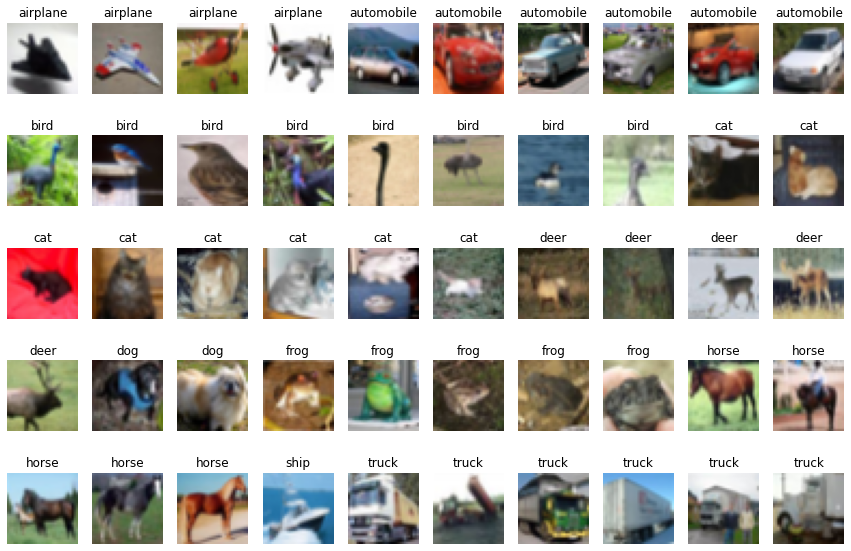

In [12]:
labels = 'airplane automobile bird cat deer dog frog horse ship truck'.split()
first_50_samples = sorted([train_dataset[i] for i in range(50)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,51):
    img = first_50_samples[i-1][0].permute(1,2,0)
    label = labels[first_50_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
num_of_batches = len(train_loader)
print(f'Number of batches: {num_of_batches}')

Number of batches: 500


In [14]:
# decorator for calculating training time
from time import perf_counter
from functools import wraps

def timer(func):
  @wraps(func)
  def wrapper(*args, **kwargs):
    start = perf_counter()
    result = func(*args, **kwargs)
    train_time = perf_counter() - start
    return (train_time, result)
  return wrapper

In [15]:
@timer
def trainer(model, train_loader, optimizer, criterion, epochs, verbose=True):
  train_losses = []
  train_accuracy = []
  history = {}

  for epoch in range(epochs):
    train_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
      b += 1
      X_train = X_train.to(device)
      y_train = y_train.to(device)

      # Apply the model
      y_pred = model(X_train)
      loss = criterion(y_pred.to(device), y_train)
  
      # the number of correct predictions
      predicted = torch.max(y_pred.data, 1)[1]
      batch_corr = (predicted == y_train).sum()
      train_corr += batch_corr.item()
          
      # Update parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print interim results
      if verbose and b % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], Step [{b}/{num_of_batches}] Loss: {loss.item():.2f} training accuracy: {(train_corr * 100 / (b * BATCH_SIZE)):.3f}")
          
    train_losses.append(loss.item())
    train_accuracy.append((train_corr / num_of_images) * 100)

  history['train loss'] = train_losses
  history['train accuracy'] = train_accuracy

  return history

## LeNet5

In [ ]:
MODEL_NAME = "lenet5_with_RRL"

In [ ]:
class LeNet5_with_RRL(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=(1, 1))
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=(1, 1))
    self.pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.RRL = RRL()
    self.tanh = nn.Tanh()

    self.fc1 = nn.Linear(in_features=16*6*6, out_features=84)
    self.fc2 = nn.Linear(in_features=84, out_features=n_classes)

  def forward(self, x):
    x = self.RRL(x)
    x = self.tanh(self.conv1(x))
    x = self.pooling(x)

    x = self.RRL(x)
    x = self.tanh(self.conv2(x))
    x = self.pooling(x)

    x = self.RRL(x)

    x = torch.flatten(x, 1)
    x = self.tanh(self.fc1(x))

    x = self.fc2(x)
    return F.softmax(x, dim=1)
    

In [ ]:
model_lenet = LeNet5_with_RRL(10)
model_lenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_lenet = torch.optim.Adam(model_lenet.parameters(), lr=LR)

In [ ]:
summary(model_lenet, (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5_with_RRL                          [100, 10]                 --
├─RRL: 1-1                               [100, 3, 33, 33]          --
├─Conv2d: 1-2                            [100, 6, 31, 31]          456
├─Tanh: 1-3                              [100, 6, 31, 31]          --
├─MaxPool2d: 1-4                         [100, 6, 15, 15]          --
├─RRL: 1-5                               [100, 6, 15, 15]          --
├─Conv2d: 1-6                            [100, 16, 13, 13]         2,416
├─Tanh: 1-7                              [100, 16, 13, 13]         --
├─MaxPool2d: 1-8                         [100, 16, 6, 6]           --
├─RRL: 1-9                               [100, 16, 6, 6]           --
├─Linear: 1-10                           [100, 84]                 48,468
├─Tanh: 1-11                             [100, 84]                 --
├─Linear: 1-12                           [100, 10]                 850
Total 

In [ ]:
lenet_train_time, history_lenet = trainer(
    model_lenet, 
    train_loader, 
    optimizer_lenet, 
    criterion, 
    EPOCHS)

Epoch [0/10], Step [100/500] Loss: 2.22 training accuracy: 20.500
Epoch [0/10], Step [200/500] Loss: 2.10 training accuracy: 26.060


We ran on google colab pro until it crashs, for hours but this was the results that could be produced with cpu

In [ ]:
torch.save(model_lenet, MODEL_PARENT_PATH + MODEL_NAME + ".pth")

In [ ]:
# summarize history for accuracy
plt.plot(history_lenet['train accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.savefig(GRAPHS_PARENT_PATH + MODEL_NAME + '_accuracy.png', \
            facecolor='white', edgecolor='none')
plt.show()


# summarize history for loss
plt.plot(history_lenet['train loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(GRAPHS_PARENT_PATH + MODEL_NAME + "_loss.png", \
            facecolor='white', edgecolor='none')
plt.show()

In [ ]:
print(f'training time for LeNet5 with RRL layer: {(lenet_train_time / 60):.2f} minutes')

## ResNet18

In [16]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1, padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=padding, bias=False)

In [17]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [18]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, downsample=None):
        super(ResNet, self).__init__()
        self.downsample = downsample
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2, padding=2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        self.RRL = RRL()

    def make_layer(self, block, out_channels, blocks, stride=1, padding=1):
        if (stride != 1) or (self.in_channels != out_channels):
            self.downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, self.downsample, padding=padding))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.RRL(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.RRL(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.RRL(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.softmax(x, dim=1)

In [19]:
model_resnet18 = ResNet(ResidualBlock, [2, 2, 2]).to(device)
model_resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters(), lr=LR)

In [20]:
summary(model_resnet18, (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 10]                 --
├─RRL: 1-1                               [100, 3, 33, 33]          --
├─Conv2d: 1-2                            [100, 16, 33, 33]         432
├─BatchNorm2d: 1-3                       [100, 16, 33, 33]         32
├─ReLU: 1-4                              [100, 16, 33, 33]         --
├─RRL: 1-5                               [100, 16, 33, 33]         --
├─Sequential: 1-6                        [100, 16, 33, 33]         --
│    └─ResidualBlock: 2-1                [100, 16, 33, 33]         --
│    │    └─Conv2d: 3-1                  [100, 16, 33, 33]         2,304
│    │    └─BatchNorm2d: 3-2             [100, 16, 33, 33]         32
│    │    └─ReLU: 3-3                    [100, 16, 33, 33]         --
│    │    └─Conv2d: 3-4                  [100, 16, 33, 33]         2,304
│    │    └─BatchNorm2d: 3-5             [100, 16, 33, 33]         32
│    │  

In [ ]:
resnet18_train_time, history_resnet18 = trainer(
    model_resnet18, 
    train_loader, 
    optimizer_resnet18, 
    criterion, 
    EPOCHS)

In [ ]:
torch.save(model_resnet18, MODEL_PARENT_PATH + MODEL_NAME + ".pth")

In [ ]:
# summarize history for accuracy
plt.plot(history_resnet18['train accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig(GRAPHS_PARENT_PATH + MODEL_NAME + '_accuracy.png', \
            facecolor='white', edgecolor='none')
plt.show()


# summarize history for loss
plt.plot(history_resnet18['train loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(GRAPHS_PARENT_PATH + MODEL_NAME + "_loss.png", \
            facecolor='white', edgecolor='none')
plt.show()

In [ ]:
print(f'training time for ResNet18 without RRL layer: {(resnet18_train_time / 60):.2f} minutes')